In [21]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D, Flatten, Dense
import cv2
import pickle

In [2]:
np.set_printoptions(threshold=np.inf)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
train_path = "G:\Jupyter Notebook Workspace\GLIM-internship\Datasets\dataset2/train"
test_path = "G:\Jupyter Notebook Workspace\GLIM-internship\Datasets\dataset2/test"

In [5]:
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
    face_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sharpen)
train_generator=train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True, 
                                                seed=42
                                                 )

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=sharpen)
test_generator=test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=False)

Found 7000 images belonging to 14 classes.
Found 1749 images belonging to 14 classes.


In [7]:
test_generator.class_indices

{'sub1': 0,
 'sub10': 1,
 'sub11': 2,
 'sub12': 3,
 'sub13': 4,
 'sub14': 5,
 'sub2': 6,
 'sub3': 7,
 'sub4': 8,
 'sub5': 9,
 'sub6': 10,
 'sub7': 11,
 'sub8': 12,
 'sub9': 13}

EfficientNet using Keras
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [8]:
from tensorflow.keras.applications import EfficientNetB0 #EfficientNetB0 has input size (224,224)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3), drop_connect_rate=0.2) #drop_connect_rate helps in regularization

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
preds=Dense(14,activation='sigmoid')(x) #final layer with sigmoid activation for N classes

model=keras.models.Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [11]:
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

In [39]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

350


In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("effNetModel1_sharpened.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

callbacks_list = [early_stopping, checkpoint]

In [41]:
r = model.fit(train_generator, 
                    steps_per_epoch=step_size_train,
                    epochs=20, 
                    validation_data=test_generator, 
                    validation_steps=8, 
                    callbacks=callbacks_list)

Epoch 1/20
350/350 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9739
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to effNetModel1_sharpened.h5


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


350/350 [==============================] - 77s 202ms/step - loss: 0.0214 - accuracy: 0.9739 - val_loss: 0.5173 - val_accuracy: 0.0000e+00
Epoch 2/20
350/350 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9984
Epoch 00002: val_accuracy did not improve from 0.00000
350/350 [==============================] - 69s 198ms/step - loss: 0.0017 - accuracy: 0.9984 - val_loss: 0.6392 - val_accuracy: 0.0000e+00
Epoch 3/20
350/350 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9943
Epoch 00003: val_accuracy did not improve from 0.00000
350/350 [==============================] - 70s 200ms/step - loss: 0.0039 - accuracy: 0.9943 - val_loss: 44.6264 - val_accuracy: 0.0000e+00
Epoch 4/20
350/350 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9966
Epoch 00004: val_accuracy improved from 0.00000 to 0.37500, saving model to effNetModel1_sharpened.h5
350/350 [==============================] - 72s 205ms/step - loss: 0.0022 - accuracy: 

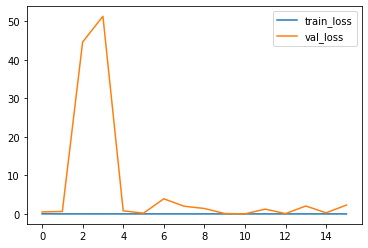

In [42]:
#Loss
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
# plt.savefig('TrainVal_loss')

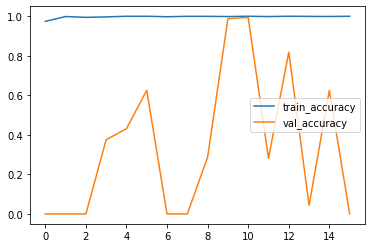

In [43]:
#Accuracy
plt.plot(r.history['accuracy'], label = 'train_accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()
# plt.savefig('TrainVal_accuracy')

In [23]:
# model.save('model_95625.h5')

In [15]:
model.load_weights('effNetModel1_sharpened_9777.h5')

## Evaluate

In [87]:
loss,metrics = model.evaluate(train_generator, verbose=2)

350/350 - 139s - loss: 0.0129 - accuracy: 0.9791 - 139s/epoch - 396ms/step


In [88]:
model.metrics_names

['loss', 'accuracy']

In [89]:
loss

0.012861443683505058

In [90]:
metrics

0.9791428446769714

## Output of a specific layer

In [92]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>

In [93]:
layer_name = model.layers[-1].name
print("last layer: ", layer_name)
print(model.input)
intermediate_layer_model = keras.Model(inputs=base_model.input,
                                       outputs=model.get_layer(layer_name).output)


last layer:  dense_2
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


In [111]:
train_imgs, train_labels = next(train_generator)
print(type(train_imgs))
print(train_labels)

<class 'numpy.ndarray'>
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [106]:
# intermediate_output = intermediate_layer_model(train_imgs)
# print(intermediate_output)

In [71]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sharpen)
train_gen_2=train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=25,
                                                class_mode='categorical',
                                                shuffle=False, 
                                                 )

Found 7000 images belonging to 14 classes.


In [135]:
# for class 0
for i in range(20):
    outputs_logits = model(next(train_gen_2)[0])
    # outputs_labels = model(next(train_generator)[1])
    print(outputs_logits)

tf.Tensor(
[[9.99898791e-01 1.59405263e-05 1.14147852e-07 5.00063813e-08
  3.37310955e-02 1.25273672e-07 1.00595564e-04 1.12944043e-07
  5.00851194e-04 2.92973601e-09 2.34013822e-08 1.16256551e-07
  1.38271480e-05 4.78464426e-05]
 [9.99734819e-01 3.11190865e-06 8.18942638e-08 8.44561498e-07
  6.07142178e-03 6.18888834e-08 5.15809807e-05 5.69141072e-08
  7.31324544e-04 2.49134018e-07 4.07766443e-09 7.69110908e-09
  1.84816254e-05 8.97868358e-06]
 [9.99939561e-01 1.12009172e-06 1.96356524e-07 3.48260528e-07
  2.24272721e-03 8.27640463e-08 4.86052049e-05 6.24115302e-08
  8.15693929e-04 9.77472148e-09 8.51747117e-09 1.31872646e-08
  9.11274583e-06 4.10994107e-06]
 [9.99752820e-01 9.25179211e-06 2.07975333e-07 3.74649801e-07
  2.94037648e-02 1.11746978e-07 3.36860452e-04 1.02403085e-07
  3.35649995e-04 1.66684497e-08 2.05719566e-08 5.93646696e-08
  6.92220192e-06 3.86188003e-06]
 [9.99776542e-01 1.99518445e-06 7.05515077e-08 6.77520461e-07
  5.12067229e-03 5.81012003e-08 5.87595714e-05 8.71

## Getting training image logits and saving them in a pickle file

In [72]:
x=np.concatenate([train_gen_2.next()[0] for i in range(train_gen_2.__len__())])
y=np.concatenate([train_gen_2.next()[1] for i in range(train_gen_2.__len__())])
print(x.shape)
print(y.shape)
# print(y)

(7000, 224, 224, 3)
(7000, 14)


In [73]:
with open('output_logits_all.pkl', 'ab') as df_file:
    for i in range(0,7000,20):
        output_logits = model(x[i:i+20])
        print("Total logits found: ",i+20)
        op_logits_np = np.array(output_logits)
        pickle.dump(obj={'x':op_logits_np}, file = df_file)

Total logits found:  20
Total logits found:  40
Total logits found:  60
Total logits found:  80
Total logits found:  100
Total logits found:  120
Total logits found:  140
Total logits found:  160
Total logits found:  180
Total logits found:  200
Total logits found:  220
Total logits found:  240
Total logits found:  260
Total logits found:  280
Total logits found:  300
Total logits found:  320
Total logits found:  340
Total logits found:  360
Total logits found:  380
Total logits found:  400
Total logits found:  420
Total logits found:  440
Total logits found:  460
Total logits found:  480
Total logits found:  500
Total logits found:  520
Total logits found:  540
Total logits found:  560
Total logits found:  580
Total logits found:  600
Total logits found:  620
Total logits found:  640
Total logits found:  660
Total logits found:  680
Total logits found:  700
Total logits found:  720
Total logits found:  740
Total logits found:  760
Total logits found:  780
Total logits found:  800
Tota

Total logits found:  6420
Total logits found:  6440
Total logits found:  6460
Total logits found:  6480
Total logits found:  6500
Total logits found:  6520
Total logits found:  6540
Total logits found:  6560
Total logits found:  6580
Total logits found:  6600
Total logits found:  6620
Total logits found:  6640
Total logits found:  6660
Total logits found:  6680
Total logits found:  6700
Total logits found:  6720
Total logits found:  6740
Total logits found:  6760
Total logits found:  6780
Total logits found:  6800
Total logits found:  6820
Total logits found:  6840
Total logits found:  6860
Total logits found:  6880
Total logits found:  6900
Total logits found:  6920
Total logits found:  6940
Total logits found:  6960
Total logits found:  6980
Total logits found:  7000


In [74]:
train_logits = []
with open('output_logits_all.pkl','rb') as read_file:
    while True:
        try:
            df = pickle.load(read_file)
            obj = df.items()
            listfromdict = list(obj)
            arr = np.array(listfromdict)[0][1]
            train_logits.append(arr)
        except EOFError:
            break

C:\Users\hp\AppData\Local\Temp/ipykernel_11744/3172444284.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(listfromdict)[0][1]


In [75]:
train_logits = np.array(train_logits).reshape(7000,14)
print(train_logits.shape)
print(train_logits)

[[9.84355450e-01 1.85511555e-04 3.15967154e-05 2.60895147e-04
  4.32349322e-03 1.01376354e-05 6.18875958e-03 9.47206790e-05
  7.23236799e-02 5.38645054e-06 2.18910645e-06 4.75430852e-07
  2.66860053e-02 3.72698443e-04]
 [9.99987364e-01 1.25416648e-07 2.37735549e-07 9.96960203e-09
  1.08894834e-04 1.20268737e-08 2.51121644e-04 8.93578260e-07
  4.25500948e-05 4.34752595e-10 1.61306133e-08 2.71082552e-08
  8.66854293e-07 1.10791677e-06]
 [9.93492901e-01 1.43798057e-03 1.41311728e-04 1.22237747e-04
  6.13831589e-03 1.19307451e-05 2.10450236e-02 2.66823708e-03
  6.09532325e-03 2.86490672e-06 1.41157489e-05 2.42163806e-05
  8.90837237e-03 4.03178565e-04]
 [9.99929786e-01 4.90793082e-06 4.72459448e-07 1.60929602e-07
  6.99223112e-03 1.70816818e-07 3.84570798e-04 4.41465147e-07
  3.83227307e-04 7.30506899e-09 4.84105662e-08 7.08642531e-08
  3.63605541e-05 4.44927764e-06]
 [9.99953270e-01 1.96455602e-07 3.02960572e-08 2.59626187e-08
  2.76182825e-03 3.14448627e-08 1.09080967e-04 1.41348323e-07


(7000, 14)

In [17]:
output_logits #just for checking 

<tf.Tensor: shape=(20, 14), dtype=float32, numpy=
array([[2.29397425e-08, 4.99418036e-07, 3.24701386e-06, 2.93263608e-10,
        9.24069172e-06, 1.54503539e-08, 1.79256205e-07, 8.94482888e-09,
        6.29562783e-06, 9.50167660e-08, 7.23135551e-10, 2.05864967e-06,
        1.59031657e-07, 9.99990940e-01],
       [4.75505249e-06, 1.05204066e-07, 1.57741961e-05, 3.71814417e-06,
        3.29763498e-05, 9.99966025e-01, 5.33274797e-05, 4.00667806e-04,
        2.90877953e-08, 6.30914769e-07, 1.18618662e-08, 1.28158248e-07,
        9.95064397e-07, 1.28900021e-04],
       [1.30479209e-04, 3.54461517e-05, 2.23360530e-06, 6.50127127e-04,
        9.98485029e-01, 7.08528842e-06, 2.67976226e-04, 7.71907605e-09,
        1.06846288e-04, 1.25166665e-07, 3.13627402e-06, 6.83224562e-06,
        2.60972229e-05, 2.81799821e-05],
       [9.99925256e-01, 1.11513771e-06, 1.21371471e-07, 1.49414802e-07,
        1.01161166e-03, 4.74998458e-08, 8.55777034e-05, 1.42141090e-08,
        1.30179408e-03, 1.21243182e

In [76]:
#fit a gaussian model
from scipy.stats import norm as dist_model
def fit(prob_pos_X):
    prob_pos = [p for p in prob_pos_X]+[2-p for p in prob_pos_X]
    pos_mu, pos_std = dist_model.fit(prob_pos)
    return pos_mu, pos_std

In [77]:
#calculate mu, std of each seen class
mu_stds = []
for i in range(14):
    pos_mu, pos_std = fit(x[np.argmax(y, axis=1)==i, i])
    mu_stds.append([pos_mu, pos_std])

print(mu_stds)

[[0.9999999, 0.76623434], [0.9999998, 0.48845023], [0.9999999, 0.6475851], [1.0000001, 0.5687766], [0.9999998, 0.71497166], [0.9999999, 0.39675856], [1.0000002, 0.38875005], [0.9999999, 0.63998777], [1.0000001, 0.5673055], [0.9999998, 0.30834118], [1.0000001, 0.40611526], [0.9999999, 0.38297123], [1.0000001, 0.5705573], [0.9999999, 0.6256619]]


In [78]:
with open('sigmoid_thresholds.pkl', 'wb') as df_file:
        pickle.dump(obj={'x':mu_stds}, file = df_file)

In [80]:
thresh = []
with open('sigmoid_thresholds.pkl', 'rb') as read_file:
        df = pickle.load(read_file)
        obj = df.items()
        listfromdict = list(obj)
        thresh = np.array(listfromdict)[0][1]
print(thresh)

[[0.9999999, 0.76623434], [0.9999998, 0.48845023], [0.9999999, 0.6475851], [1.0000001, 0.5687766], [0.9999998, 0.71497166], [0.9999999, 0.39675856], [1.0000002, 0.38875005], [0.9999999, 0.63998777], [1.0000001, 0.5673055], [0.9999998, 0.30834118], [1.0000001, 0.40611526], [0.9999999, 0.38297123], [1.0000001, 0.5705573], [0.9999999, 0.6256619]]


C:\Users\hp\AppData\Local\Temp/ipykernel_11744/126362509.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  thresh = np.array(listfromdict)[0][1]


### Predicting on test set

In [82]:
predictions = model.predict(test_generator, verbose = 1)

88/88 [==============================] - 17s 164ms/step


In [53]:
print(predictions.shape)
# np.round(predictions) 
predictions

(1749, 14)


array([[9.99982715e-01, 4.79435812e-07, 2.14087635e-07, 8.14968892e-09,
        1.95479064e-04, 1.32607632e-08, 3.95567222e-05, 4.05894074e-09,
        3.66120308e-04, 8.39864983e-11, 2.18124843e-08, 1.24171713e-08,
        5.15699276e-06, 7.16930617e-06],
       [9.99882817e-01, 2.93051362e-05, 6.87399506e-07, 4.48719646e-07,
        2.11832412e-02, 1.59836901e-07, 1.09101750e-03, 4.19069607e-07,
        2.64154456e-04, 5.40134826e-09, 1.19123179e-07, 1.20816151e-06,
        6.83551698e-05, 1.01229216e-05],
       [9.99908686e-01, 5.89604099e-07, 3.18214148e-08, 6.11431261e-08,
        1.06548378e-02, 1.43184335e-08, 1.07540545e-04, 1.23518813e-08,
        4.12188456e-05, 7.12413406e-10, 3.25839755e-09, 1.62379763e-08,
        7.69302733e-06, 2.26153611e-06],
       [9.99653459e-01, 1.39603435e-06, 2.61970672e-06, 5.53638574e-06,
        2.30884459e-03, 1.16174867e-07, 8.26804244e-05, 2.78350250e-08,
        6.72340335e-04, 1.15754011e-08, 2.66463722e-08, 2.98164622e-08,
        5.996

In [54]:
np.argmax(predictions, axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [55]:
test_generator.class_indices

{'sub1': 0,
 'sub10': 1,
 'sub11': 2,
 'sub12': 3,
 'sub13': 4,
 'sub14': 5,
 'sub2': 6,
 'sub3': 7,
 'sub4': 8,
 'sub5': 9,
 'sub6': 10,
 'sub7': 11,
 'sub8': 12,
 'sub9': 13}

In [83]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=1))

In [99]:
import itertools

def plot_confusion_matrix(cm, classes, 
                          normalize= False, 
                          title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
            horizontalalignment = "center",
            color = "white" if cm[i,j] > thresh else "black", fontsize=14)
    plt.tight_layout()
   
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=16) 
    

Confusion Matrix, Without Normalization
[[100   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 112   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 138   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 140   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  95   0   2   2   0   0   0   1   0]
 [  0   0   0   0   0   0 111   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0 138   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0   0 109   0   0   0   1   0]
 [  0   0   0   0  25   0   0   0   0  93   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0 155   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 148   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 148]]

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.0

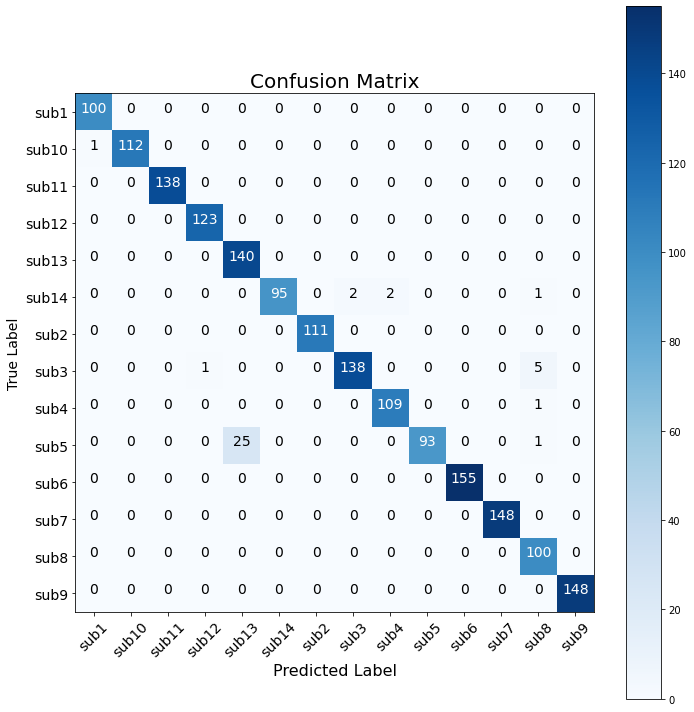

In [100]:
cm_plot_labels = ['sub1','sub10','sub11','sub12',
            'sub13','sub14','sub2','sub3',
            'sub4','sub5','sub6','sub7',
            'sub8','sub9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

from sklearn.metrics import classification_report
print("\n",classification_report(test_generator.classes, y_pred=np.argmax(predictions, axis=1)))

In [59]:
accuracy_score(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=1))

0.9777015437392796

In [70]:
test3_path = "G:\Jupyter Notebook Workspace\GLIM-internship\Datasets\dataset2/test3"
test_generator2=test_datagen.flow_from_directory(test3_path,
                                                target_size=(224,224),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=False)


Found 14 images belonging to 14 classes.


In [78]:
print("Batch Size for Input Image : ",test_generator2[0][0].shape)
print("Batch Size for Output Image : ",test_generator2[0][1].shape)
print("Image Size of first image : ",test_generator2[0][0][0].shape)
print("Output of first image : ",test_generator2[0][1][0].shape)
print("--------------\n")
print(test_generator2[0][0])

Batch Size for Input Image :  (14, 224, 224, 3)
Batch Size for Output Image :  (14, 14)
Image Size of first image :  (224, 224, 3)
Output of first image :  (14,)
--------------



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [71]:
pred = model.predict(test_generator2, verbose = 1)

1/1 [==============================] - 1s 846ms/step


In [72]:
print(pred.shape)
# np.round(predictions) 
pred

(14, 14)


array([[7.52335668e-01, 1.30419275e-02, 1.56169804e-02, 6.73698112e-02,
        3.65911238e-02, 1.45462602e-02, 9.11858864e-03, 2.67330818e-02,
        1.92915741e-02, 7.69014936e-03, 4.71943896e-03, 1.34849492e-02,
        1.46977948e-02, 4.76265652e-03],
       [2.69016270e-02, 6.18144512e-01, 1.07982783e-02, 1.78216994e-02,
        7.94617925e-03, 1.36748672e-01, 4.36212262e-03, 1.67663135e-02,
        9.64175612e-02, 9.84211359e-03, 1.88980009e-02, 2.31640041e-02,
        5.87648666e-03, 6.31240755e-03],
       [9.98081523e-04, 1.20248122e-03, 9.86090541e-01, 1.05242070e-03,
        5.45070914e-04, 8.06294382e-04, 2.37394101e-03, 6.23831293e-04,
        1.19491236e-03, 2.40823283e-04, 2.67536123e-03, 4.34909656e-04,
        1.01607991e-03, 7.45224766e-04],
       [5.82946371e-03, 3.11597227e-03, 8.60566273e-03, 7.47005522e-01,
        1.53045217e-03, 8.52887426e-03, 2.46285857e-03, 4.62609855e-03,
        1.85811147e-03, 1.31486938e-03, 1.52242533e-03, 2.26213364e-03,
        2.078

In [74]:
np.argmax(pred, axis=1)

array([ 0,  1,  2,  3,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)